# Plant Disease Prediction using EfficientNetV2L

This notebook presents an approach to predict plant diseases using the EfficientNetV2L model. The problem is a multiclass classification problem, where the goal is to classify an image of a plant into one of several possible disease categories.

## Libraries

The code begins by importing necessary Python libraries:

- **Data Manipulation**: `pandas` and `numpy` are used for data manipulation and mathematical operations.
- **Visualization**: `matplotlib` and `seaborn` are used for data visualization.
- **Machine Learning**: `sklearn` is used for machine learning tasks such as splitting the dataset and evaluating the model. `tensorflow` and `keras` are used for building and training the deep learning model.
- **Image Processing**: `cv2` and `PIL` are used for image processing tasks.
- **Model**: `EfficientNetV2L` from `keras.applications` is the pre-trained model used for this task.

## Model Architecture

The model architecture is defined using the `Sequential` API from Keras. The base model is `EfficientNetV2L`, which is pre-trained on the ImageNet dataset. The pre-trained layers of the base model are frozen to preserve the learned features. 

Following the base model, several layers are added:

- `GlobalAveragePooling2D` layer to reduce the spatial dimensions of the output from the base model.
- Several `BatchNormalization` layers to normalize the activations of the neurons in the network.
- `Dropout` layers to prevent overfitting by randomly setting a fraction of input units to 0 during training.
- `Dense` layers, which are fully connected layers, for classification.

The model is compiled with the `adam` optimizer, `sparse_categorical_crossentropy` loss function, and accuracy as the metric.

## Dataset

The dataset used is the Crop disease dataset, which consists of about 1,00,000 images of size (256,224,224). The dataset is not loaded in this code snippet.

---

Remember to replace the placeholders with the actual values or descriptions as per your project details. Happy Kaggle-ing!


# Importing necessary libraries for our task

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc
from sklearn.model_selection import train_test_split

import cv2
#from google.colab.patches import cv2_imshow
from PIL import Image 
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub 

from keras.applications import EfficientNetV2L
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D

2024-03-11 19:38:31.924686: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 19:38:31.924780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 19:38:32.061784: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Exploration and Visualization

This notebook presents the steps to explore and visualize the data for a plant disease prediction problem. The problem is a multiclass classification problem, where the goal is to classify an image of a plant into one of several possible disease categories.

In [2]:
# getting the training and validation data from the 
data_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [3]:
# getting the training data from the directory, and dividing it into batches
train_data = tf.keras.preprocessing.image_dataset_from_directory(
 train_dir,
    batch_size=256,
  image_size=(224,224), shuffle=True
)

Found 70295 files belonging to 38 classes.


In [4]:
# getting the validation data from the directory, and dividing it into batches
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
 valid_dir,
    batch_size=256,
  image_size=(224,224), shuffle=True
)

Found 17572 files belonging to 38 classes.


In [5]:
path = "/kaggle/input/new-plant-diseases-dataset/test/test"
test_folder = os.listdir(path)
test_folder[:5]

['TomatoEarlyBlight6.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'TomatoYellowCurlVirus6.JPG',
 'PotatoHealthy2.JPG',
 'TomatoYellowCurlVirus5.JPG']

In [6]:
print(f'The total nummber of classes is {len(train_data.class_names)}')
class_labels = train_data.class_names
class_labels

The total nummber of classes is 38


['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [7]:
# Augmenting the dataset, by generating more variations of the images
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Use the 'datagen' to preprocess the images loaded by 'image_data_from_directory'
train_scaled_data = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=256,shuffle=True,
    class_mode='sparse'
)

# test_scaled_data = datagen.flow_from_directory(
#     "/kaggle/input/100-bird-species/test",
#     target_size=(224, 224),
#     batch_size=256,shuffle=True
# )

valid_scaled_data = datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=256,shuffle=True,
    class_mode='sparse'
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [8]:
#  Identify unique plants and count the number of diseases
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [9]:
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Tomato', 'Grape', 'Orange', 'Soybean', 'Squash', 'Potato', 'Corn_(maize)', 'Strawberry', 'Peach', 'Apple', 'Blueberry', 'Cherry_(including_sour)', 'Pepper,_bell', 'Raspberry']


In [10]:
print("Number of plants: {}".format(len(plants)))
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of plants: 14
Number of diseases: 26


## Data Exploration

The unique plants and the number of diseases are identified. The number of images for each disease is counted and the distribution is plotted. This helps to understand the balance of the dataset.

In [11]:
#  Count the number of images for each disease and plot the distribution
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Tomato___Late_blight,1851
Tomato___healthy,1926
Grape___healthy,1692
Orange___Haunglongbing_(Citrus_greening),2010
Soybean___healthy,2022
Squash___Powdery_mildew,1736
Potato___healthy,1824
Corn_(maize)___Northern_Leaf_Blight,1908
Tomato___Early_blight,1920
Tomato___Septoria_leaf_spot,1745


Text(0.5, 1.0, 'Images per each class of plant disease')

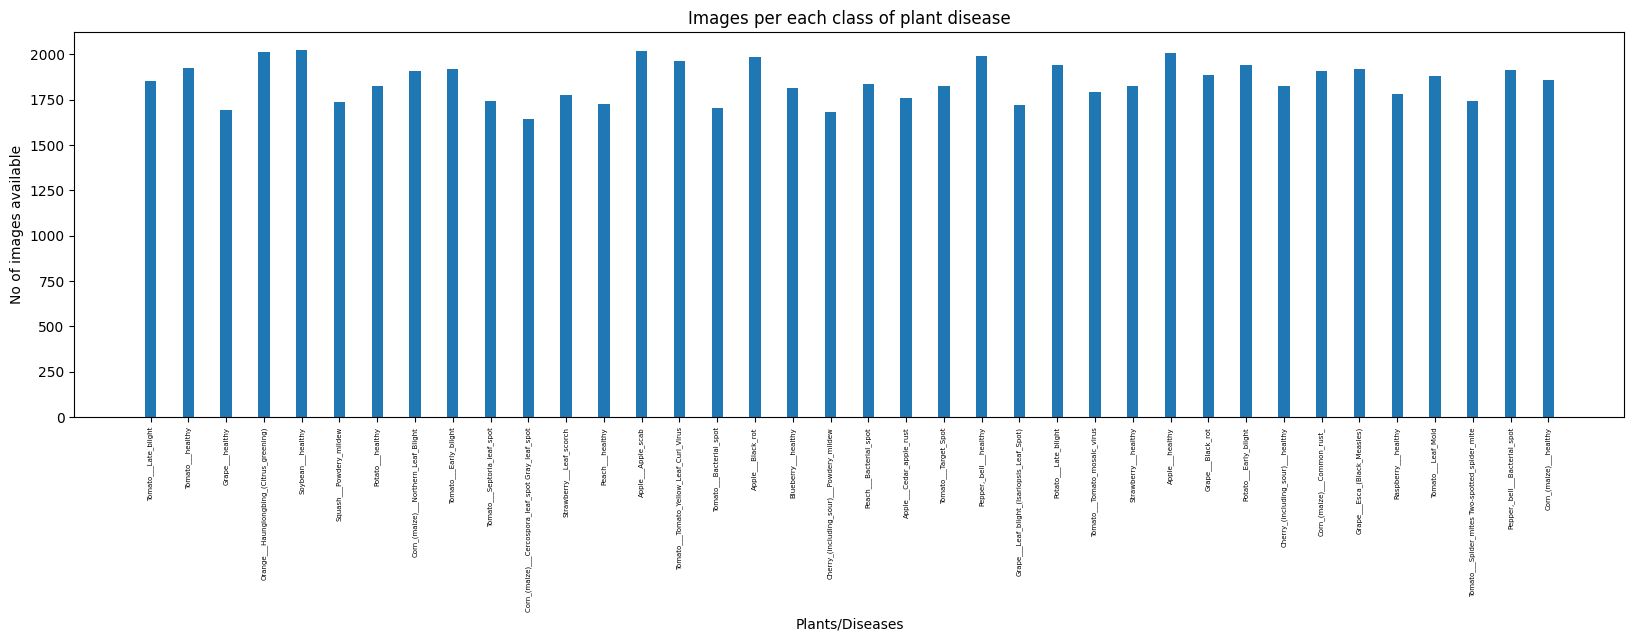

In [12]:
# plotting number of images available for each disease
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [13]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 70295 images for training


In [14]:
img, label = train_scaled_data[0]
print(img.shape, label)

(256, 224, 224, 3) [16. 32.  8. 27. 26.  3. 23. 37. 18. 11. 33. 16. 11.  5. 16.  7. 23.  8.
 18. 26. 13. 24.  7. 21. 11. 26. 17.  3.  4.  0. 37.  9.  8. 19. 19. 26.
 23. 33. 18. 27. 14.  8.  9. 13. 18. 16.  4.  3. 12. 14. 23. 37. 34.  2.
 19. 29. 20.  0. 11. 33. 17. 36.  8. 25.  4. 30. 33. 19. 30. 26. 23. 30.
 10. 24. 10. 30.  5. 31. 21. 12. 13. 18.  0. 16.  2.  0. 22. 35. 16. 19.
 18. 19.  3. 37. 12. 34.  2. 21.  9.  6. 19. 31.  0. 23. 18. 24. 17. 14.
  9. 36. 33. 24. 32. 21. 16.  2. 27.  8. 36.  7. 35. 20. 20. 19. 20. 15.
 31. 14. 34. 23. 15. 12. 28.  5. 16. 27.  3. 37. 33.  3.  6. 32.  9. 15.
 34. 17.  3. 29. 21.  2. 31.  0. 13.  8. 19. 26.  4. 23. 36. 30. 27. 23.
 22. 11.  1. 36.  1. 36. 10. 28.  8.  9. 33. 22. 18. 31. 18.  2.  6. 34.
 27. 30. 28. 37.  3. 28. 24. 16.  2. 28.  1. 33. 31.  8. 34. 13. 28. 19.
  1. 37. 22. 22. 10. 19. 33. 15. 35.  1. 14. 14. 35. 12. 11. 33. 15. 35.
 12. 24. 29. 17. 36. 12.  1. 25. 19. 36. 36.  7. 32. 37. 29. 10. 20. 37.
 18. 29. 15. 25. 36.  2. 25. 27.

In [15]:
# total number of classes in train set
len(train_scaled_data.classes)

70295

## Data Visualization



In [16]:
#A function is defined to display an image from the training dataset. This helps to get a sense of what the images look like.
def show_image(train_scaled_image, n):
    # Get the first batch of data
    images, labels = next(train_scaled_data)

    # Select the first image from the batch
    image = images[0]

    # If the image data is in the range [0, 1], scale it to the range [0, 255]
    if image.max() <= 1.0:
        image *= 255.0

    # Convert the image data to an integer type
    image = image.astype('uint8')

    # Plot the image
    plt.imshow(image)
    plt.show()


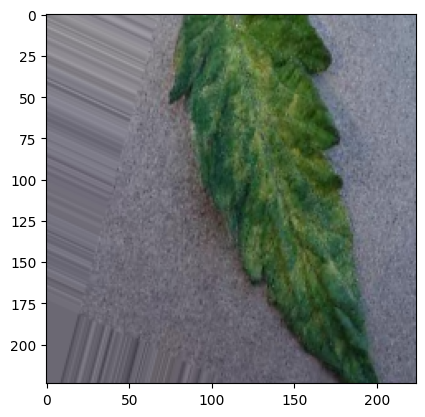

In [17]:
# Display an image from the training dataset
show_image(train_scaled_data, 4)

In [18]:
random_seed = 7

# Set the random seed for Python
random.seed(random_seed)

# Set the random seed for NumPy
np.random.seed(random_seed)

# Set the random seed for TensorFlow
tf.random.set_seed(random_seed)

In [19]:
# setting the batch size
batch_size = 32

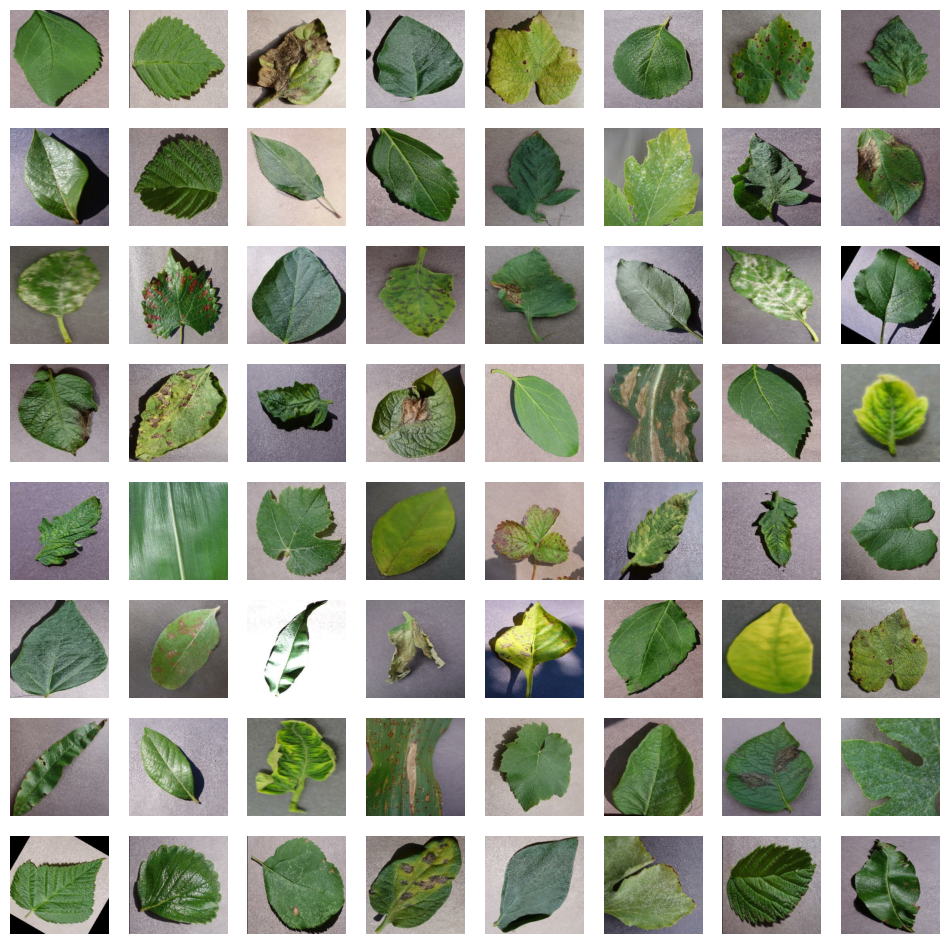

In [20]:
#A function is defined to display a batch of training images. This helps to visualize the diversity of the images in the dataset.

def show_batch(data, n=8):
    # Get the first batch of data
    images, labels = next(iter(data))

    # Select the first n*n images from the batch
    images = images[:n*n]

    # If the image data is in the range [0, 1], scale it to the range [0, 255]
    if tf.reduce_max(images[0]) <= 1.0:
        images *= 255.0

    # Convert the image data to an integer type
    images = tf.cast(images, tf.uint8)

    # Plot the images in a n by n grid
    fig, axs = plt.subplots(n, n, figsize=(12, 12))
    axs = axs.ravel()
    for i in range(n*n):
        axs[i].imshow(images[i])
        axs[i].axis('off')  # Hide the axes
    plt.show()

# Show the first batch of training images
show_batch(train_data)

# EfficientNet: A Revolutionary Architecture in Deep Learning

EfficientNet, has become a go-to architecture for many challenging tasks, including object recognition, image segmentation, and even language processing. Its success stems from its ability to balance two critical factors in deep learning: computational efficiency and model performance.

EfficientNet addresses the trade-off between accuracy and resource consumption by introducing a novel approach called "compound scaling". By systematically scaling the model’s dimensions (width, depth, and resolution) in a principled manner, EfficientNet achieves unprecedented levels of efficiency without compromising accuracy. This method allows the model to strike an optimal balance, making it adaptable to various computational budgets and hardware capabilities.

One of the strengths of EfficientNet lies in its ability to balance these three dimensions through a principled approach. Its impact can be observed in various domains. For instance, EfficientNet has opened doors for deploying state-of-the-art models on edge devices with limited computational resources, making deep learning accessible in scenarios where resource efficiency is crucial.

## Learning Resources

Here are some resources to learn more about EfficientNet:

- [What is EfficientNet? The Ultimate Guide](https://www.bing.com/ck/a?!&&p=1bef90d419a3807aJmltdHM9MTcwOTY4MzIwMCZpZ3VpZD0wY2ZiMDQwOC05NjZkLTZkMjctMTQyNC0xNTZhOTc2YjZjM2ImaW5zaWQ9NTIxMQ&ptn=3&ver=2&hsh=3&fclid=0cfb0408-966d-6d27-1424-156a976b6c3b&psq=What+is+EfficientNet%3f+The+Ultimate+Guide%5d&u=a1aHR0cHM6Ly9ibG9nLnJvYm9mbG93LmNvbS93aGF0LWlzLWVmZmljaWVudG5ldC8&ntb=1): This blog post dives deep into the architecture of EfficientNet, explores the technical details behind compound scaling, and understands how compound scaling has transformed the field of deep learning.
- [EfficientNet - Hugging Face](https://www.bing.com/ck/a?!&&p=c909028f441649f7JmltdHM9MTcwOTY4MzIwMCZpZ3VpZD0wY2ZiMDQwOC05NjZkLTZkMjctMTQyNC0xNTZhOTc2YjZjM2ImaW5zaWQ9NTIwNA&ptn=3&ver=2&hsh=3&fclid=0cfb0408-966d-6d27-1424-156a976b6c3b&psq=EfficientNet+-+Hugging+Face&u=a1aHR0cHM6Ly9odWdnaW5nZmFjZS5jby9kb2NzL3RyYW5zZm9ybWVycy9tYWluL2VuL21vZGVsX2RvYy9lZmZpY2llbnRuZXQ&ntb=1): This documentation provides a comprehensive guide on how to use EfficientNet with Hugging Face’s Transformers library.
- [EfficientNet: A Breakthrough in Machine Learning Model Architecture](https://www.javatpoint.com/efficientnet-a-breakthrough-in-machine-learning-model-architecture#:~:text=EfficientNet%20is%20a%20family%20of,to%20scaling%20the%20model%20architecture.): This article provides an overview of the EfficientNet model and its advantages.
- [EfficientNet: Improving Accuracy and Efficiency through AutoML and Model Scaling](https://blog.research.google/2019/05/efficientnet-improving-accuracy-and.html): This is the official blog post from Google AI, where EfficientNet was first introduced.
- [EfficientNet Explained | Papers with Code](https://paperswithcode.com/method/efficientnet): This is the site where you gain learn about the model in depth, by reading the research paper, and also getting access to the code to make modifications in the architecture of the model


# Model Training and Evaluation

This notebook presents the steps to train and evaluate a model for a plant disease prediction problem. The problem is a multiclass classification problem, where the goal is to classify an image of a plant into one of several possible disease categories.

## Model Definition

The model architecture is defined using the Sequential API from Keras. The base model is EfficientNetV2L, which is pre-trained on the ImageNet dataset. The pre-trained layers of the base model are frozen to preserve the learned features.

Following the base model, several layers are added:

- `GlobalAveragePooling2D` layer to reduce the spatial dimensions of the output from the base model.
- Several `BatchNormalization` layers to normalize the activations of the neurons in the network.
- `Dropout` layers to prevent overfitting by randomly setting a fraction of input units to 0 during training.
- `Dense` layers, which are fully connected layers, for classification.

The model is compiled with the `adam` optimizer, `sparse_categorical_crossentropy` loss function, and accuracy as the metric.

In [21]:
base_model = EfficientNetV2L(input_shape=(224,224,3),
                         include_top=False, weights='imagenet')

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model
model2 = Sequential()

model2.add(base_model)
model2.add(GlobalAveragePooling2D())
model2.add(BatchNormalization())  # Add batch normalization layer
model2.add(Dropout(0.5))  # Add dropout layer
model2.add(Dense(256, activation='relu'))  # Add a dense layer with 256 units
model2.add(BatchNormalization())  # Add another batch normalization layer
model2.add(Dropout(0.5))  # Add another dropout layer
model2.add(Dense(len(class_labels), activation='softmax'))

# Use a smaller learning rate
opt = keras.optimizers.Adam(learning_rate=0.0001)

model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

473176280/473176280 [==============================] - 4s 0us/step


## Model Training

The model is trained using the training data for a specified number of epochs. The validation data is used to evaluate the model’s performance at the end of each epoch.

Several callbacks are used during training:

- `EarlyStopping` to stop training when the validation loss has stopped improving for a certain number of epochs.
- `ModelCheckpoint` to save the model after every epoch where the validation loss has improved.
- `TensorBoard` to write logs to a directory for TensorBoard.
- `ReduceLROnPlateau` to reduce the learning rate when the validation loss has stopped improving for a certain number of epochs.

In [22]:
# Define early stopping callback
my_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.001, verbose=1)
]

# Train the model
history2 = model2.fit(
    train_data,
    epochs=30,
    validation_data=valid_data,
    callbacks=[my_callbacks]
)

model2.summary()  

Epoch 1/30


2024-03-11 19:40:47.234244: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetv2-l/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1710186064.771859      80 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


275/275 [==============================] - ETA: 0s - loss: 2.7175 - accuracy: 0.3138
Epoch 1: val_loss improved from inf to 1.33065, saving model to model.01-1.33.h5
275/275 [==============================] - 1204s 4s/step - loss: 2.7175 - accuracy: 0.3138 - val_loss: 1.3307 - val_accuracy: 0.7478 - lr: 1.0000e-04
Epoch 2/30
275/275 [==============================] - ETA: 0s - loss: 1.3672 - accuracy: 0.6011
Epoch 2: val_loss improved from 1.33065 to 0.57197, saving model to model.02-0.57.h5
275/275 [==============================] - 1124s 4s/step - loss: 1.3672 - accuracy: 0.6011 - val_loss: 0.5720 - val_accuracy: 0.8541 - lr: 1.0000e-04
Epoch 3/30
275/275 [==============================] - ETA: 0s - loss: 1.0031 - accuracy: 0.7000
Epoch 3: val_loss improved from 0.57197 to 0.41678, saving model to model.03-0.42.h5
275/275 [==============================] - 1126s 4s/step - loss: 1.0031 - accuracy: 0.7000 - val_loss: 0.4168 - val_accuracy: 0.8863 - lr: 1.0000e-04
Epoch 4/30
275/275 [==

In [23]:
model2.save('plant_disease_efficientNetV2_modified2.h5')  

## Model Evaluation

The trained model is saved for future use. The training and validation loss and accuracy are plotted to visualize the model's performance over time.

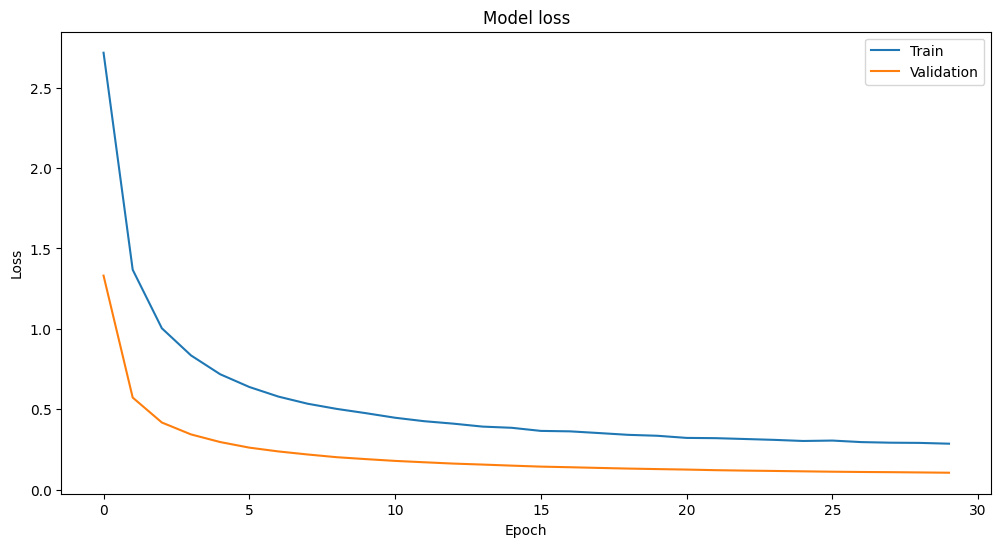

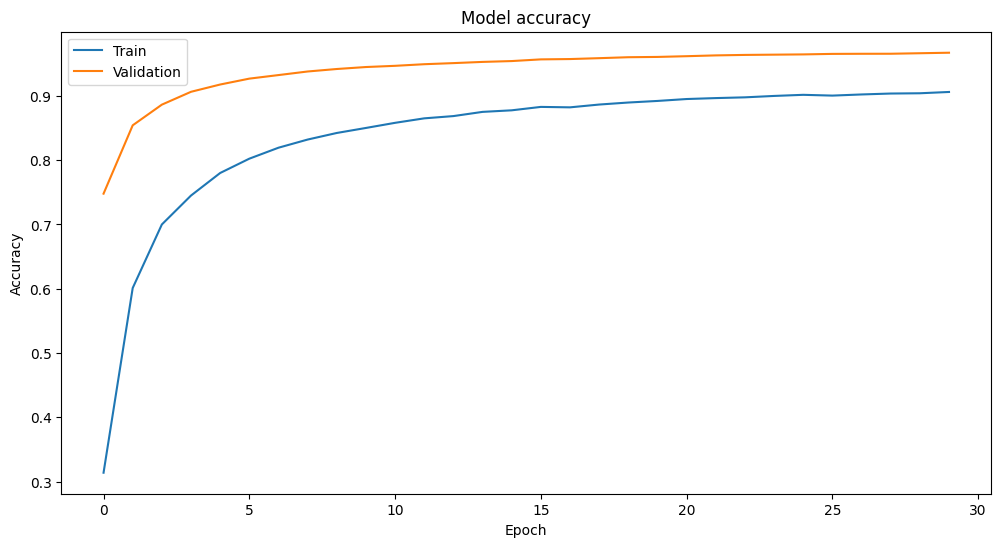

In [24]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Create a new figure for the accuracy
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()